In [34]:
import os
import glob
from tqdm.notebook import tqdm
import itertools

import torch 
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

### Create customized dataset from original images files

In [35]:
class MonetImageDataset(Dataset):
    def __init__(self, root: str='/kaggle/input/gan-getting-started', mode: bool='train', width: int=256, heigth: int=256) -> None:
        self.transform = transforms.Compose([
            transforms.RandomCrop((heigth, width)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.to_rgb = lambda image: Image.new("RGB", image.size).paste(image)
        self.mode = mode
        if self.mode == 'train':
            # Domain A (Real world) <---> Domain B (Monet-ish world)
            self.files_A = glob.glob(os.path.join(root+'/photo_jpg')+'/*.jpg')[:250]
            self.files_B = glob.glob(os.path.join(root+'/monet_jpg')+'/*.jpg')[:250]
        elif self.mode == 'test':
            self.files_A = glob.glob(os.path.join(root+'/photo_jpg')+'/*.jpg')[250:301]
            self.files_B = glob.glob(os.path.join(root+'/monet_jpg')+'/*.jpg')[250:301]
    
    def __getitem__(self, index: int) -> dict:
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = self.to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = self.to_rgb(image_B)
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A': item_A, 'B': item_B}
    
    def __len__(self) -> int:
        return max(len(self.files_A), len(self.files_B))

In [36]:
train_dataset = MonetImageDataset(mode='train')
test_dataset = MonetImageDataset(mode='test')

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=2, pin_memory=True)

In [37]:
def show_imgs() -> None:
    imgs = next(iter(test_dataloader))
    real_A = imgs['A'].type(torch.Tensor)
    real_B = imgs['B'].type(torch.Tensor)
    grid_A = make_grid(real_A, nrow=5, normalize=True)
    grid_B = make_grid(real_B, nrow=5, normalize=True)
    grid = torch.cat((grid_A, grid_B), dim=1)
    plt.imshow(grid.detach().cpu().permute(1, 2, 0))
    plt.title("Real image (U) | Monet's image (D)")
    plt.axis('off')
    plt.show()

#### Show samples in the test set

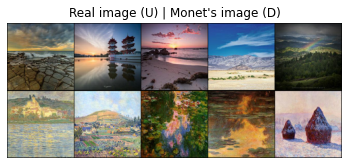

In [38]:
show_imgs()

### Define a CycleGAN, which is inspired by https://github.com/aitorzip/PyTorch-CycleGAN/blob/67da8f9e2b69bd68763451803c7700aaccc92f18/models.py

In [39]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]
        # output shape (B, 64, 256, 256)

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2
        # output shape (B, 256, 64, 64)

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]
        # output shape (B, 256, 64, 64)

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2
        # output shape (B, 64, 256, 256)

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]
        # output shape (B, 3, 256, 256)

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]
        # output shape (B, 64, 128, 128)

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]
        # output shape (B, 128, 64, 64)

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]
        # output shape (B, 256, 32, 32)

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]
        # output shape (B, 512, 31, 31)

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]
        # output shape (B, 1, 30, 30)

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten, without softmax ...
        return functional.avg_pool2d(x, x.shape[2:]).view(x.shape[0], -1)
        # output shape (B, 1)

#### Loss function for CycleGAN
A convential GAN has the following loss:
$$ \mathcal{L}_{GAN} = \mathbb{E}_{x\sim p_{data}}[\log D(x)]+\mathbb{E}_{z\sim p_z}[\log (1-D(G(z))] $$
where $z$ is sampled from latent distribution $p_z$
In CycleGAN, the latent space is now the input space, i.e. in our case, the 'real world images', and we hope the model can convert the real world image to Monet-ish image, which requires it to learn the mapping: real world (X) -> Monet-ish world (Y). However, since the data in both real world and Monet-ish are not one-to-one correlated, the training must start from both sides (no one is special). For this purpose, we train two GANs: $G(x) = \hat{y}$ and $F(y) = \hat{x}$, together with their discriminator $D_Y(G(x))\to[0,1]$ and $D_X(F(Y))\to[0,1]$. Each one of them has a convential GAN loss:
$$ \mathcal{L}_{GAN} (G, D_Y, X, Y)= \mathbb{E}_{y\sim p_{data}(y)}[\log D_Y(y)]+\mathbb{E}_{x\sim p_{data}(x)}[\log (1-D_Y(G(x))] $$ 
$$ \mathcal{L}_{GAN} (F, D_X, X, Y)= \mathbb{E}_{x\sim p_{data}(x)}[\log D_X(x)]+\mathbb{E}_{y\sim p_{data}(y)}[\log (1-D_X(F(y))] $$ 
Also, we do not hope the model convert a dog in real world into a cat in Monet-ish and vice versa, if we only apply the above two loss, there can be a case like this and the generators are great enough to fool their discriminators, althougth they are generating two samples which are not related at all. So we need to introduce another loss to measure the consistancy between the two-side-generated samples. Specifically, just like AE, we use real data $x$ and $y$ in both $X$, $Y$ spaces, and test them with the processes $F(G(x))$ and $G(F(y))$, to see if they can recover the original samples:
$$ \mathcal{L}_{cyc}(G,F) = \mathbb{E}_{x\sim p_{data}(x)}[\Vert F(G(x)) - x \Vert_1] + \mathbb{E}_{y\sim p_{data}(y)}[\Vert G(F(y)) - y \Vert_1] $$
One more thing... whether $G$ of $F$, it should not destory the samples from its original space. i.e. $G(y)$ should still be $y$ and $F(x)$ should still be $x$, so the last loss will be included as identity loss:
$$ \mathcal{L}_{ide}(G,F) = \mathbb{E}_{x\sim p_{data}(x)}[\Vert F(x) - x \Vert_1] + \mathbb{E}_{y\sim p_{data}(y)}[\Vert G(y) - y \Vert_1] $$ 
So far, the only thing is to combine these four parts together, and we get the final loss for CycleGAN:
$$ \mathcal{L}(G,F,D_X,D_Y) = \mathcal{L}_{GAN} (G, D_Y, X, Y) + \mathcal{L}_{GAN} (F, D_X, X, Y) + \mathcal{L}_{cyc}(G,F) + \mathcal{L}_{ide}(G,F)$$

In [40]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [65]:
class Trainer:
    def __init__(self,
                 G: Generator, 
                 F: Generator, 
                 DX: Discriminator, 
                 DY: Discriminator, 
                 lr: float=2e-4, 
                 betas: tuple=(0.5, 0.999),
                 n_epochs: int=20,
                 decay_epoch: int=5) -> None:
        self.G = G.to('cuda:0')
        self.F = F.to('cuda:0')
        self.DX = DX.to('cuda:0')
        self.DY = DY.to('cuda:0')
        self.G.apply(weights_init_normal)
        self.F.apply(weights_init_normal)
        self.DX.apply(weights_init_normal)
        self.DY.apply(weights_init_normal)
        
        self.criterion_GAN = nn.MSELoss()
        self.criterion_cyc = nn.L1Loss()
        self.criterion_ide = nn.L1Loss()
        
        self.optimizer_G = optim.Adam(itertools.chain(self.G.parameters(), self.F.parameters()), lr=lr, betas=betas)
        self.optimizer_DX = optim.Adam(self.DX.parameters(), lr=lr, betas=betas)
        self.optimizer_DY = optim.Adam(self.DY.parameters(), lr=lr, betas=betas)
        
        self.lr_schedular_G = optim.lr_scheduler.LambdaLR(self.optimizer_G, lr_lambda=LambdaLR(n_epochs, 0, decay_epoch).step)
        self.lr_schedular_DX = optim.lr_scheduler.LambdaLR(self.optimizer_DX, lr_lambda=LambdaLR(n_epochs, 0, decay_epoch).step)
        self.lr_schedular_DY = optim.lr_scheduler.LambdaLR(self.optimizer_DY, lr_lambda=LambdaLR(n_epochs, 0, decay_epoch).step)
        
        self.n_epochs = n_epochs
    
    def identity_loss(self, real_A: torch.Tensor, real_B: torch.Tensor) -> torch.Tensor:
        loss_id_G = self.criterion_ide(self.G(real_B), real_B)
        loss_id_F = self.criterion_ide(self.F(real_A), real_A)
        loss_id = (loss_id_G + loss_id_F) / 2.0
        return loss_id
    
    def GAN_loss(self, real_A: torch.Tensor, real_B: torch.Tensor, valid: torch.Tensor) -> tuple:
        fake_B = self.G(real_A)
        loss_GAN_G = self.criterion_GAN(self.DY(fake_B), valid)
        fake_A = self.F(real_B)
        loss_GAN_F = self.criterion_GAN(self.DX(fake_A), valid)
        loss_GAN = (loss_GAN_G + loss_GAN_F) / 2.0
        return (loss_GAN, fake_A, fake_B)
    
    def cycle_loss(self, real_A: torch.Tensor, real_B: torch.Tensor, fake_A: torch.Tensor, fake_B: torch.Tensor) -> tuple:
        recov_A = self.F(fake_B)
        loss_cyc_A = self.criterion_cyc(recov_A, real_A)
        recov_B = self.G(fake_A)
        loss_cyc_B = self.criterion_cyc(recov_B, real_B)
        loss_cyc = (loss_cyc_A + loss_cyc_B) / 2.0
        return (loss_cyc, recov_A, recov_B)
    
    def DX_loss(self, real_A: torch.Tensor, fake_A: torch.Tensor, valid: torch.Tensor, fake: torch.Tensor) -> torch.Tensor:
        loss_real = self.criterion_GAN(self.DX(real_A), valid)
        loss_fake = self.criterion_GAN(self.DX(fake_A.detach()), fake)
        loss_DX = (loss_real + loss_fake) / 2.0
        return loss_DX
    
    def DY_loss(self, real_B: torch.Tensor, fake_B: torch.Tensor, valid: torch.Tensor, fake: torch.Tensor) -> torch.Tensor:
        loss_real = self.criterion_GAN(self.DY(real_B), valid)
        loss_fake = self.criterion_GAN(self.DY(fake_B.detach()), fake)
        loss_DY = (loss_real + loss_fake) / 2.0
        return loss_DY
        
    def train(self, show_intermediate: bool=True) -> None:
        
        # Training
        
        for ep in range(self.n_epochs):
            pbar_train = tqdm(train_dataloader)
            pbar_test = tqdm(test_dataloader)
            loss_g = []
            loss_d = []
            # train
            self.G.train()
            self.F.train()
            self.DX.train()
            self.DY.train()
            
            for _, batch in enumerate(pbar_train):
                real_A = batch['A'].float().to('cuda:0')
                real_B = batch['B'].float().to('cuda:0')
                
                valid = torch.ones((real_A.shape[0], ))[:, None].to('cuda:0')
                fake = torch.zeros((real_A.shape[0], ))[:, None].to('cuda:0')
                
                # train Generator G and F
                
                self.optimizer_G.zero_grad()
                
                # identity loss
                loss_ide = self.identity_loss(real_A, real_B)
                
                # GAN loss
                loss_GAN, fake_A, fake_B = self.GAN_loss(real_A, real_B, valid)
                
                # cycle loss
                loss_cyc, _, _ = self.cycle_loss(real_A, real_B, fake_A, fake_B)
                
                # total loss
                loss = loss_GAN + 10.0 * loss_cyc + 5.0 * loss_ide
                
                loss.backward()
                self.optimizer_G.step()
                loss_g.append(loss.item())
                
                # train discriminator DX
                self.optimizer_DX.zero_grad()
            
                loss_DX = self.DX_loss(real_A, fake_A, valid, fake)
                
                loss_DX.backward()
                self.optimizer_DX.step()
                
                # train discriminator DY
                self.optimizer_DY.zero_grad()
                
                loss_DY = self.DY_loss(real_B, fake_B, valid, fake)
                
                loss_DY.backward()
                self.optimizer_DY.step()
                
                loss_d.append((loss_DX.item()+loss_DY.item())/2)
                
                pbar_train.set_description(f"Training: Epoch [{ep+1}/{self.n_epochs}], Generator loss: {np.mean(loss_g):.3f}, Discriminator loss: {np.mean(loss_d):.3f}")
            
            loss_g.clear()
            loss_d.clear()
            
            # Validation
            self.G.eval()
            self.F.eval()
            self.DX.eval()
            self.DY.eval()
            
            with torch.no_grad():
                for _, batch in enumerate(pbar_test):
                    real_A = batch['A'].float().to('cuda:0')
                    real_B = batch['B'].float().to('cuda:0')

                    valid = torch.ones((real_A.shape[0], ))[:, None].to('cuda:0')
                    fake = torch.zeros((real_A.shape[0], ))[:, None].to('cuda:0')

                    # identity loss
                    loss_ide = self.identity_loss(real_A, real_B)
                    # GAN loss
                    loss_GAN, fake_A, fake_B = self.GAN_loss(real_A, real_B, valid)
                    # cycle loss
                    loss_cyc, recov_A, recov_B = self.cycle_loss(real_A, real_B, fake_A, fake_B)
                    # total loss
                    loss = loss_GAN + 10.0 * loss_cyc + 5.0 * loss_ide
                    
                    loss_g.append(loss.item())

                    loss_DX = self.DX_loss(real_A, fake_A, valid, fake)
                    loss_DY = self.DY_loss(real_B, fake_B, valid, fake)

                    loss_d.append((loss_DX.item()+loss_DY.item())/2)

                    pbar_test.set_description(f"Validation: Epoch [{ep+1}/{self.n_epochs}], Generator loss: {np.mean(loss_g):.3f}, Discriminator loss: {np.mean(loss_d):.3f}")
                
                if show_intermediate and (ep+1) % 3 == 0:
                    real_A_grid = make_grid(real_A, nrow=5, normalize=True)
                    real_B_grid = make_grid(real_B, nrow=5, normalize=True)
                    fake_A_grid = make_grid(fake_A, nrow=5, normalize=True)
                    fake_B_grid = make_grid(fake_B, nrow=5, normalize=True)
                    recov_A_grid = make_grid(recov_A, nrow=5, normalize=True)
                    recov_B_grid = make_grid(recov_B, nrow=5, normalize=True)
                    grid = torch.cat((real_A_grid, recov_A_grid, fake_B_grid, real_B_grid, recov_B_grid, fake_A_grid), dim=1)
                    plt.imshow(grid.detach().cpu().permute(1, 2, 0))
                    plt.title("Original | Recovered | Transformed")
                    plt.axis('off')
                    plt.show()
        

In [66]:
G = Generator(input_nc=3, output_nc=3)
F = Generator(input_nc=3, output_nc=3)
DX = Discriminator(input_nc=3)
DY = Discriminator(input_nc=3)

In [67]:
trainer = Trainer(G, F, DX, DY, n_epochs=10)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

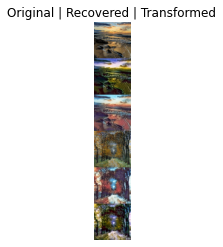

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

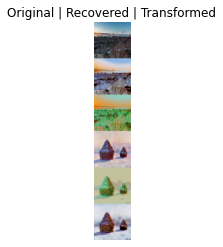

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

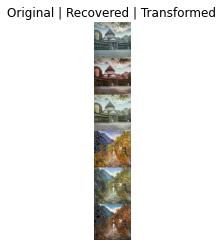

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [68]:
trainer.train()

In [71]:
model_root = '/kaggle/working/MonetCycleGAN'
if os.path.exists(model_root):
    pass
else:
    os.mkdir(model_root)
torch.save(G.state_dict(), model_root+'/G_10epochs.pth')
torch.save(F.state_dict(), model_root+'/F_10epochs.pth')
torch.save(DX.state_dict(), model_root+'/DX_10epochs.pth')
torch.save(DY.state_dict(), model_root+'/DY_10epochs.pth')

#### Test the model

In [74]:
def test():
    with torch.no_grad():
        imgs = next(iter(test_dataloader))
        real_A = imgs['A'].float().to('cuda:0')
        real_B = imgs['B'].float().to('cuda:0')
        grid_real_A = make_grid(real_A, nrow=5, normalize=True)
        grid_real_B = make_grid(real_B, nrow=5, normalize=True)
        gen_A = G(real_A)
        gen_B = F(real_B)
        grid_gen_A = make_grid(gen_A, nrow=5, normalize=True)
        grid_gen_B = make_grid(gen_B, nrow=5, normalize=True)
        grid = torch.cat((grid_real_A, grid_gen_A, grid_real_B, grid_gen_B), dim=1)
        plt.figure(figsize=(20, 20))
        plt.imshow(grid.detach().cpu().permute(1, 2, 0))
        plt.title("Real (T) | Real (G) | Monet's (T) | Monet's (G)")
        plt.axis('off')
        plt.show()

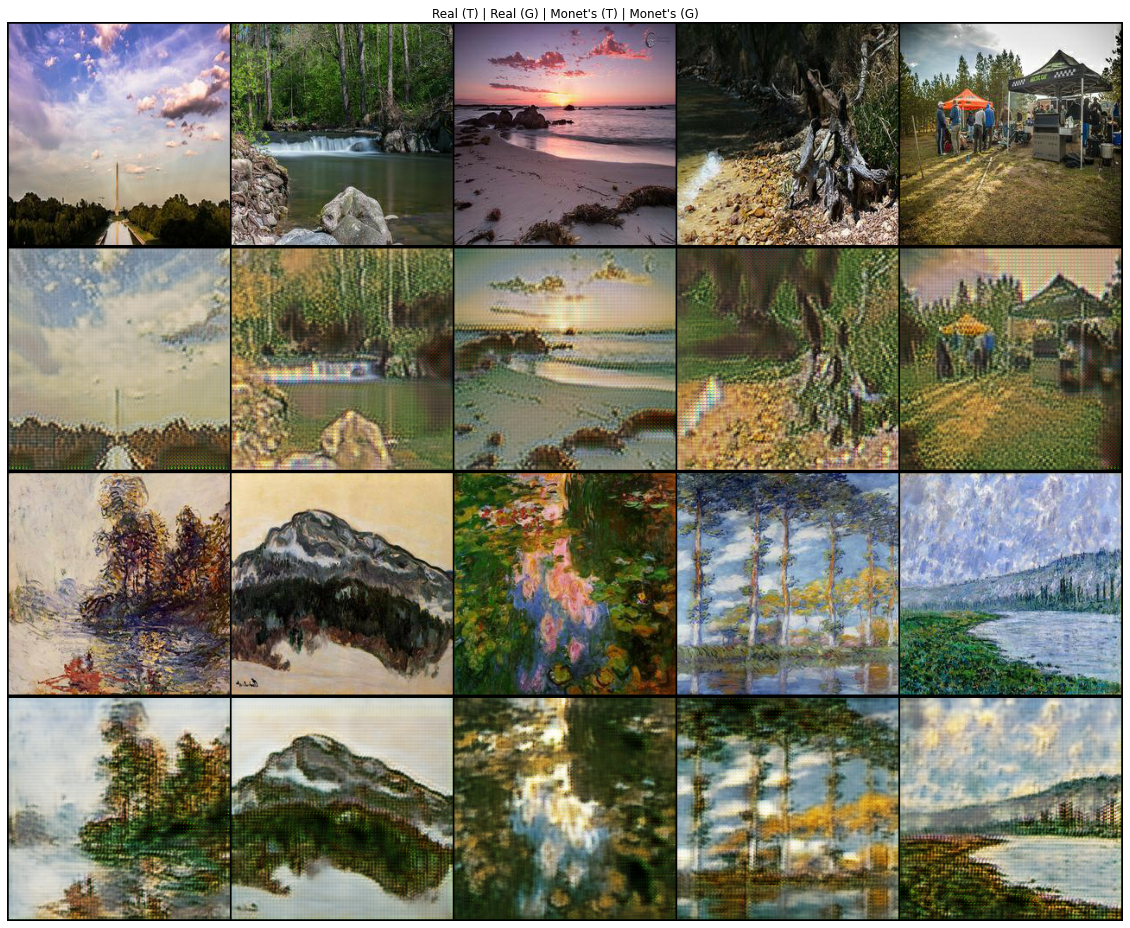

In [75]:
test()